In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
#from Bio import SeqIO
from glob import glob
import os

from mito.genotyping import nucleotide_mutation_prob, mutation_prob, COUNTS_COLUMNS


# Plotting style
sns.set_style('white')
sns.set_context('notebook')


def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [3]:
import scanpy as sc
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/johard/miniconda3/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


In [4]:
adata = sc.read('../../data/YFV2001_gene_expression/results/YFV2001_230127_scanpy_data.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 1236 × 63386
    obs: 'Day', 'Project_ID', 'Clone_ID', 'mem_score', 'n_mutations_tree'
    var: 'transcript_length', 'ENSG_ID', 'plain_name'

# Annotate gene type

In [6]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

# Calculate QC

We calculate the percentage of mitocondrial and ribosomal genes per 
cell and add to the metadata. This will be helpfull to visualize them across different 
metadata parameteres (i.e. datasetID and chemistry version). There are several ways 
of doing this, and here manually calculate the proportion of mitochondrial reads and 
add to the metadata table.

Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): 
    "High proportions are indicative of poor-quality cells (Islam et al. 2014; 
    Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from 
    perforated cells. The reasoning is that mitochondria are larger than 
    individual transcript molecules and less likely to escape through 
    tears in the cell membrane."

 First, let Scanpy calculate some general qc-stats for genes and cells with 
the function `sc.pp.calculate_qc_metrics`, similar to `calculateQCmetrics` in Scater. 
It can also calculate proportion of counts for specific gene populations, so first 
we need to define which genes are mitochondrial, ribosomal and hemoglogin.

In [7]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [8]:
adata.var.head()

,transcript_length,ENSG_ID,plain_name,mt,ribo,hb,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
unique_name,,,,,,,,,,
DDX11L1,1356.250000,ENSG00000223972,DDX11L1,False,False,False,1,0.008091,99.919094,10.0
WASH7P,1560.400000,ENSG00000227232,WASH7P,False,False,False,283,3.350324,77.103560,4141.0
MIR1302-10,461.666667,ENSG00000243485,MIR1302-10,False,False,False,0,0.000000,100.000000,0.0
FAM138A,888.500000,ENSG00000237613,FAM138A,False,False,False,0,0.000000,100.000000,0.0
OR4G4P,483.000000,ENSG00000268020,OR4G4P,False,False,False,0,0.000000,100.000000,0.0


In [47]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes

heh = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
#adata.obs['percent_mt2'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

hehe = heh.copy()
adata.obs['percent_mt2'] = hehe

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [48]:
adata.obs['percent_mt2']

P1299_1097    0.097048
P1299_1098    0.115735
P1299_1099    0.082115
P1299_1100    0.086613
P1299_1101    0.101546
                ...   
P3128_1187    0.071093
P3128_1188    0.064222
P3128_1189    0.098468
P3128_1190    0.065872
P3128_1191    0.124002
Name: percent_mt2, Length: 1236, dtype: float32

In [49]:
adata

AnnData object with n_obs × n_vars = 1236 × 63386
    obs: 'Day', 'Project_ID', 'Clone_ID', 'mem_score', 'n_mutations_tree', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'percent_mitt'
    var: 'transcript_length', 'ENSG_ID', 'plain_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'Project_ID_colors'

# Quality control

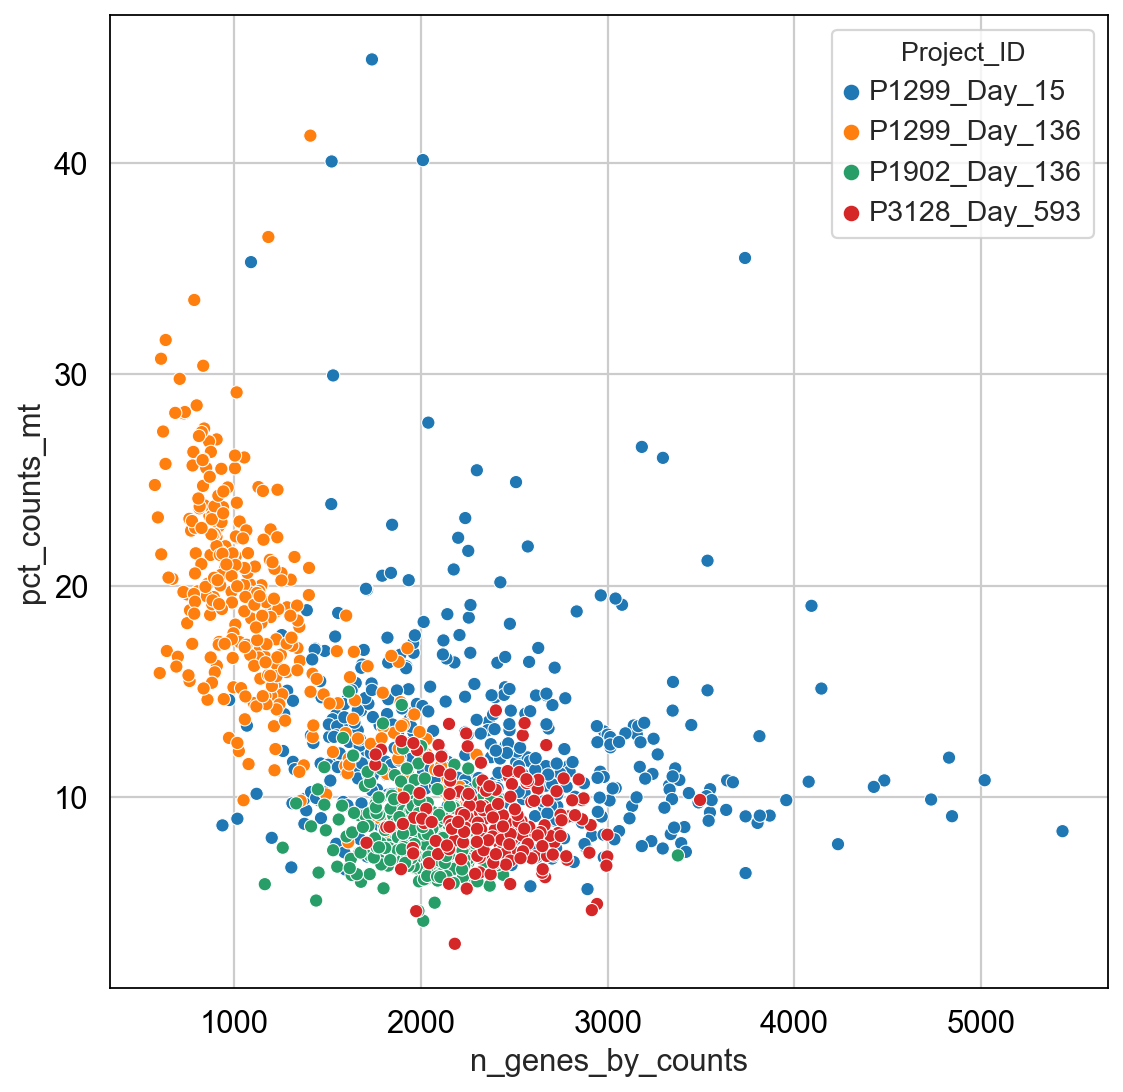

In [50]:
# n_genes_by_count: we think this is the number of genes the cell expresses
# judging on the counts for those genes somehow

fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.scatterplot(x='n_genes_by_counts', y='pct_counts_mt', hue='Project_ID',
                data=adata.obs,  ax=ax)

plt.show()

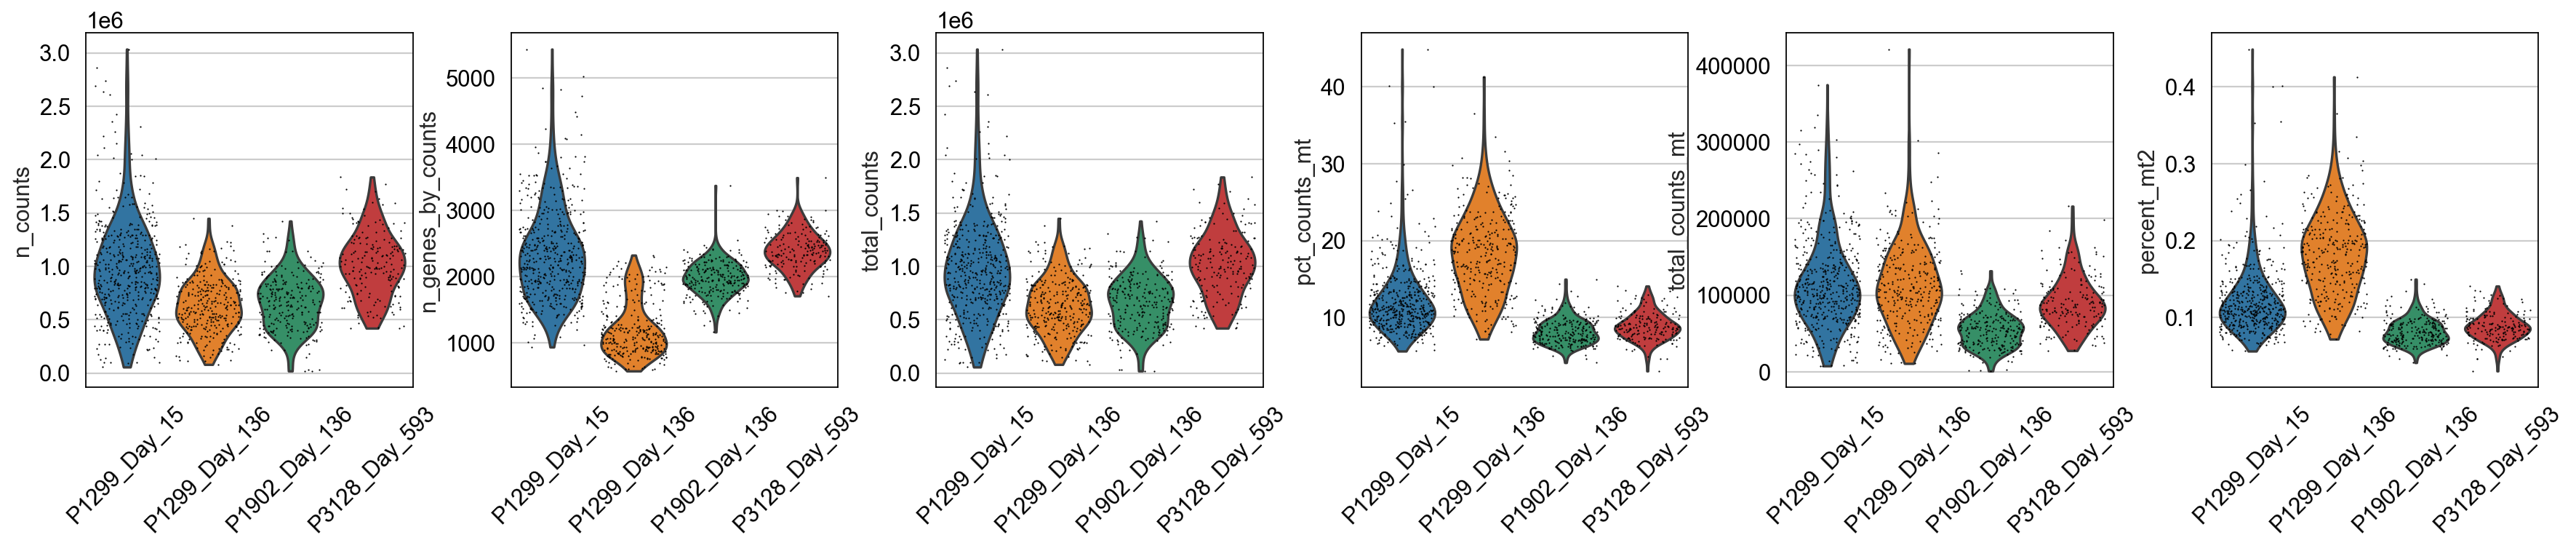

In [51]:
sc.pl.violin(adata, ['n_counts', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'total_counts_mt', 'percent_mt2' ],
             jitter=0.4, groupby = 'Project_ID', rotation= 45)


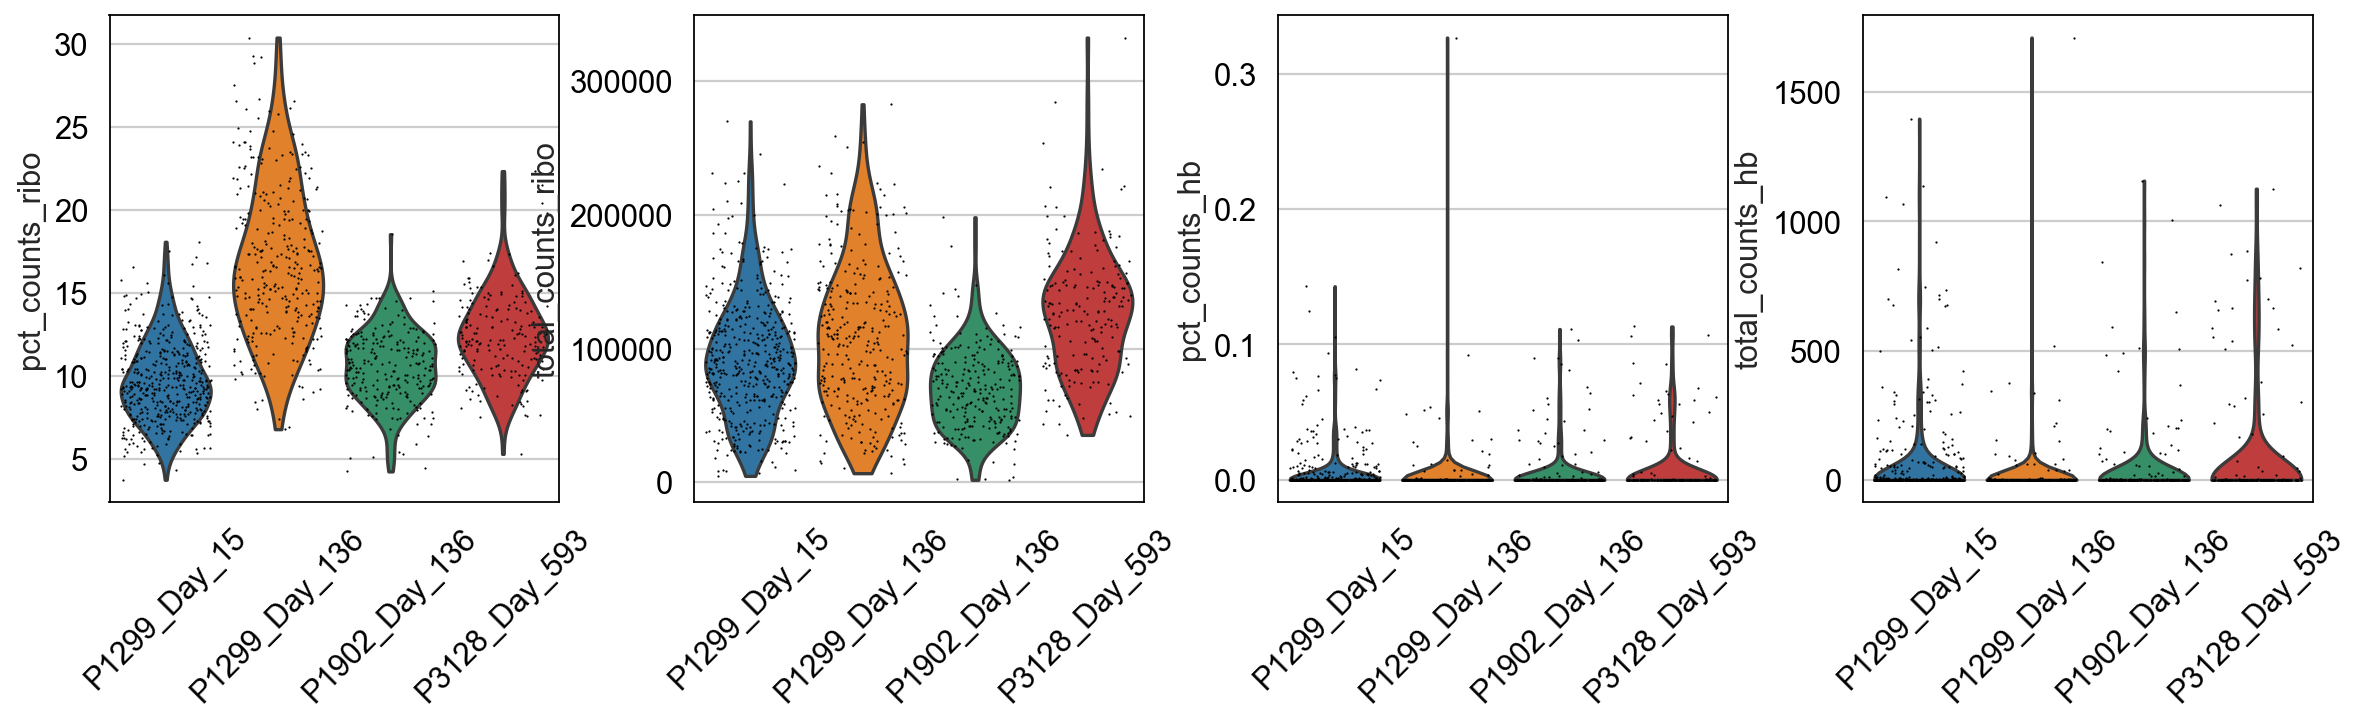

In [52]:
sc.pl.violin(adata, ['pct_counts_ribo', 'total_counts_ribo', 'pct_counts_hb', 'total_counts_hb'],
             jitter=0.4, groupby = 'Project_ID', rotation= 45)

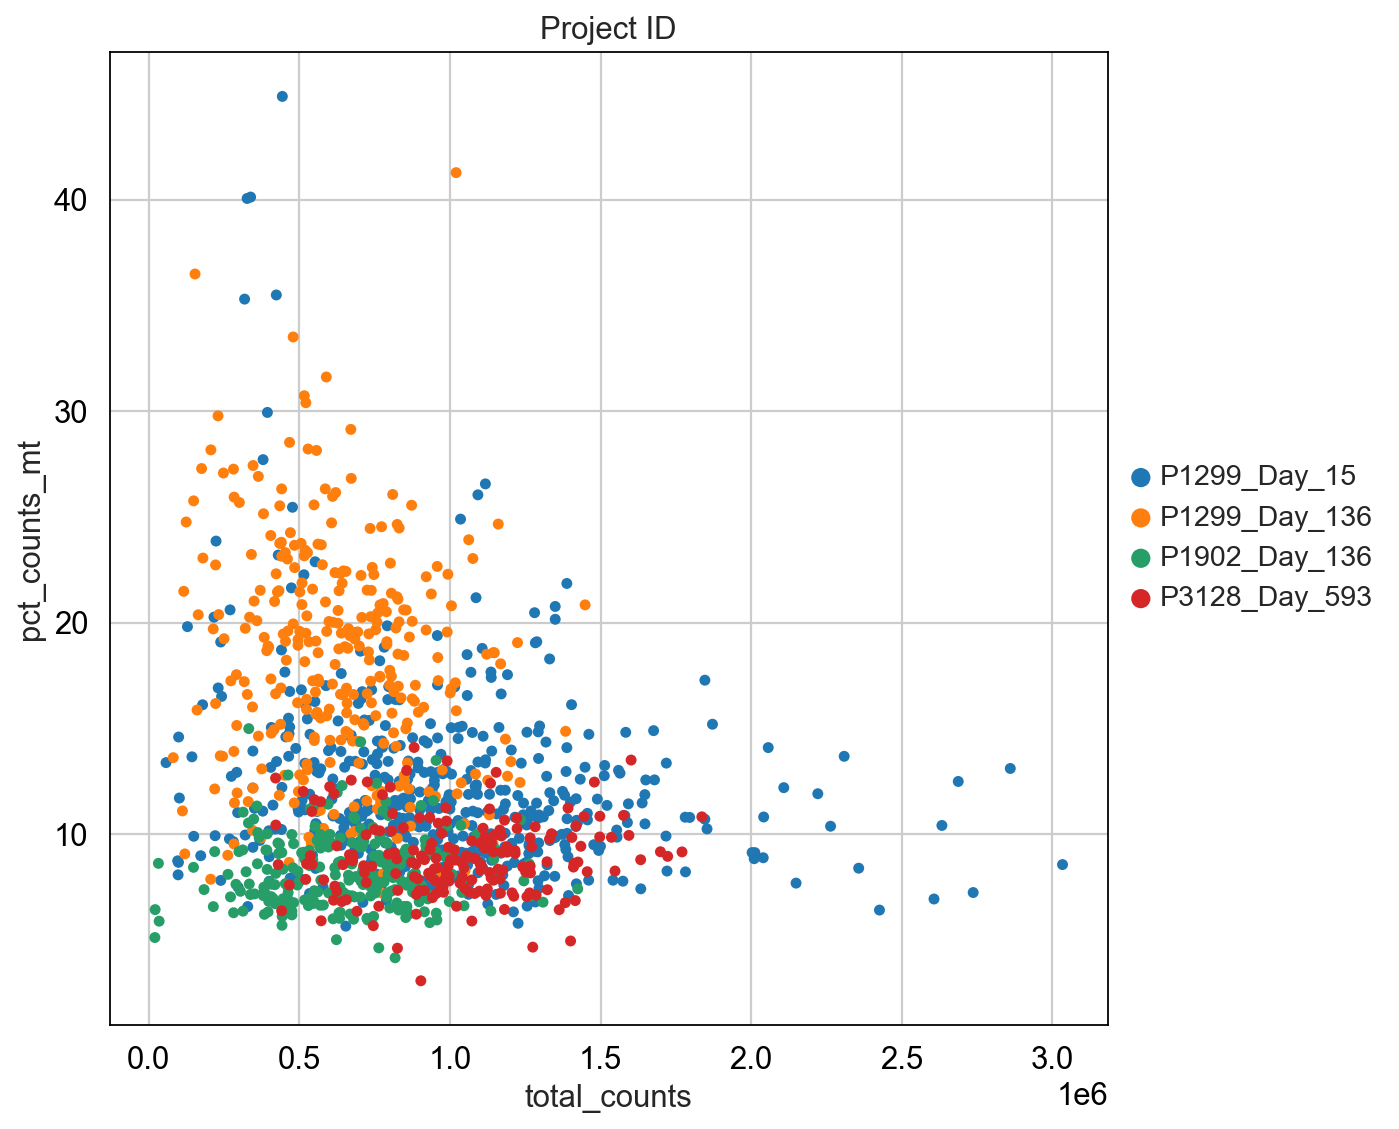

In [53]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="Project_ID", ax=ax)


# Filtering

A standard approach is to filter cells with low amount of reads as well as genes that are present in at least a certain amount of cells. Here we will only consider cells with at least 200 detected genes and genes need to be expressed in at least 3 cells. Please note that those values are highly dependent on the library preparation method used.


In [54]:

# Remove bad plate: P1299 should match P1902, it clearly doesn't and has low number of
# genes expressed and suspiciously high MT percent
adata = adata[adata.obs['Project_ID'] != 'P1299_Day_136']

In [55]:
print(adata.n_obs, adata.n_vars)

928 63386


In [56]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

/Users/johard/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


928 24944


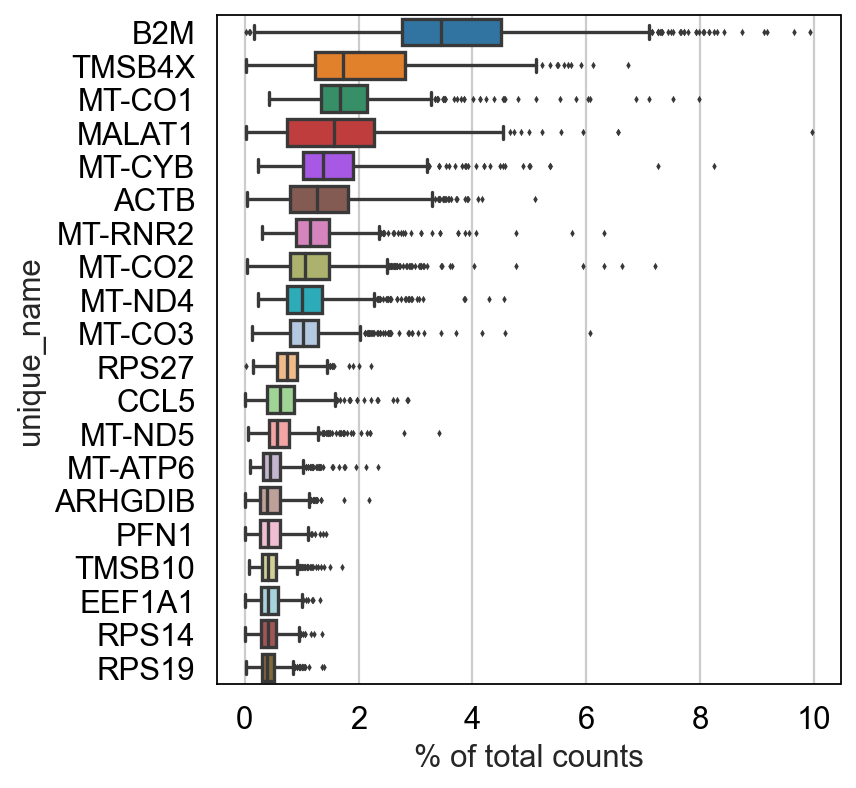

In [57]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 constitutes up to 30% of the UMIs from a single cell and the other top genes are mitochondrial and ribosomal genes. It is quite common that nuclear lincRNAs have correlation with quality and mitochondrial reads, so high detection of MALAT1 may be a technical issue. Let us assemble some information about such genes, which are important for quality control and downstream filtering.

## Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial and low proportion ofribosomal reads. It could be wise to remove those cells, if we have enough cells left after filtering. <br>Another option would be to either remove all mitochondrial reads from the dataset and hope that the remaining genes still have enough biological signal. <br>A third option would be to just regress out the `percent_mito` variable during scaling. In this case we had as much as 99.7% mitochondrial reads in some of the cells, so it is quite unlikely that there is much cell type signature left in those. <br>Looking at the plots, make reasonable decisions on where to draw the cutoff. In this case, the bulk of the cells are below 20% mitochondrial reads and that will be used as a cutoff. We will also remove cells with less than 5% ribosomal reads.


In [178]:
adata.n_obs

1236

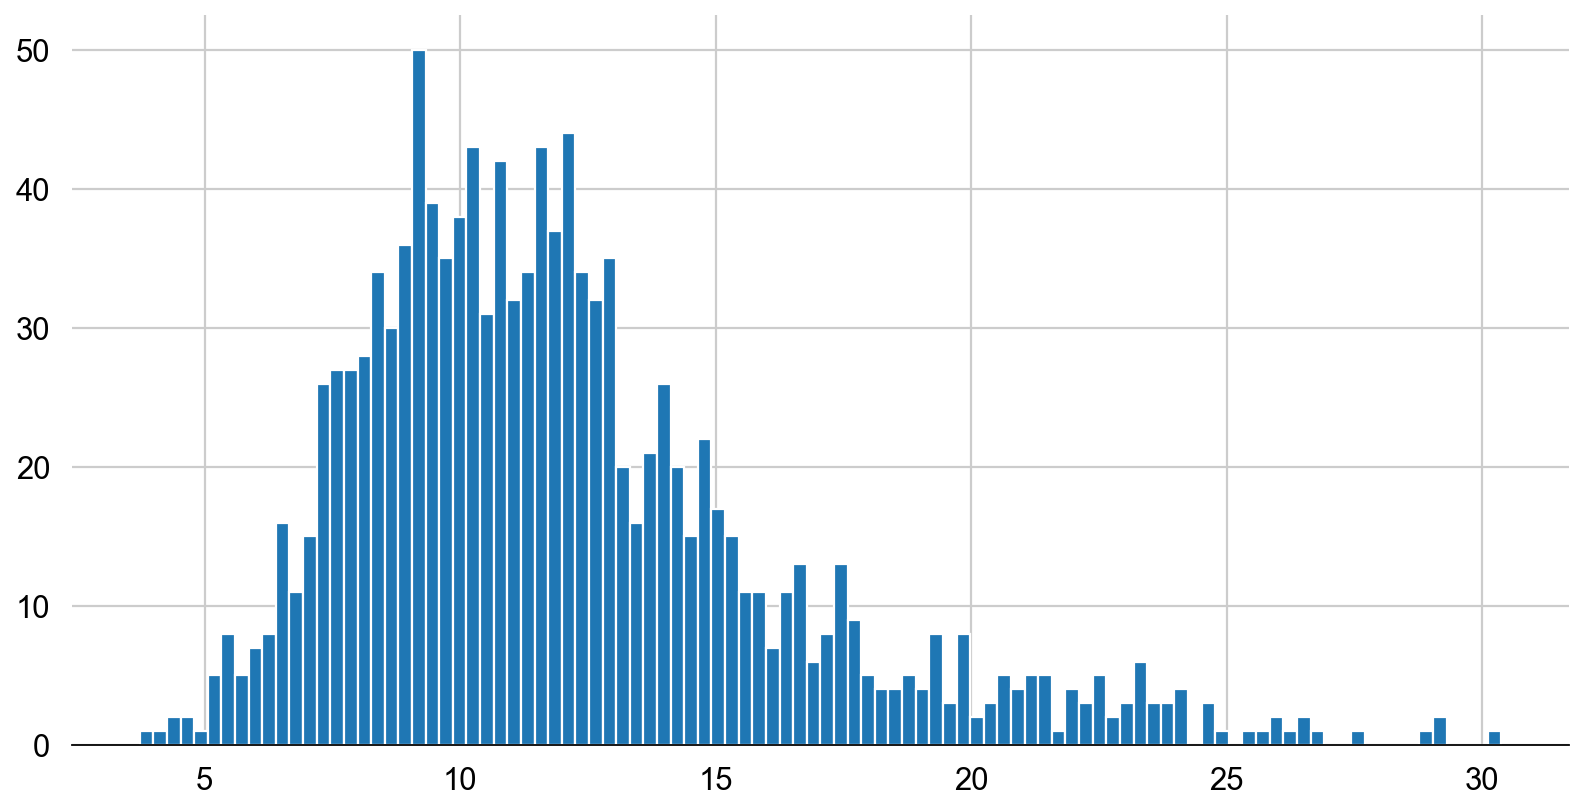

In [179]:
with plot_style():
    adata.obs['pct_counts_ribo'].hist(bins=100)

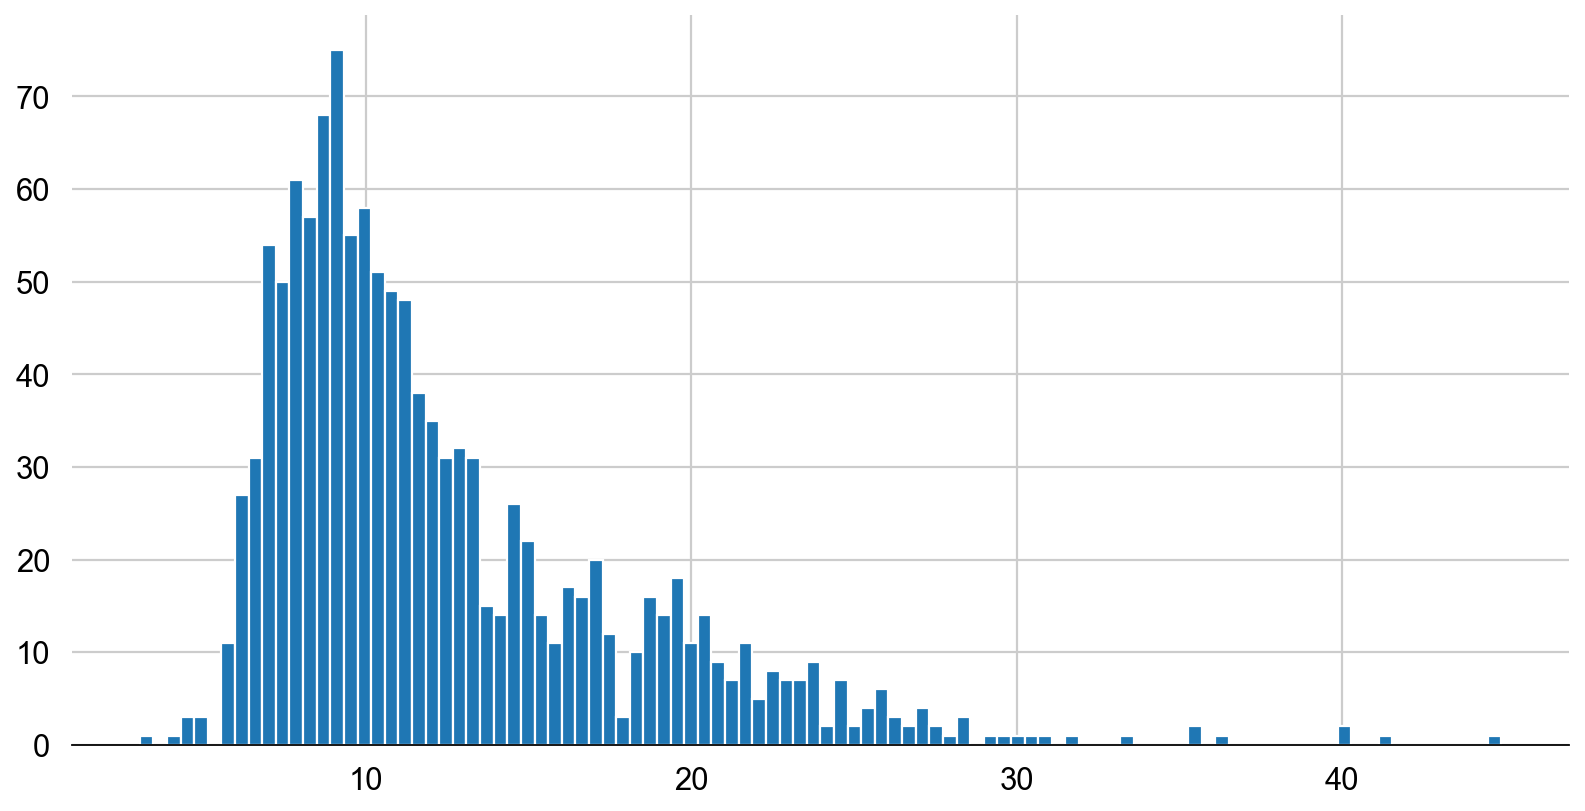

In [180]:
with plot_style():
    adata.obs['pct_counts_mt'].hist(bins=100)

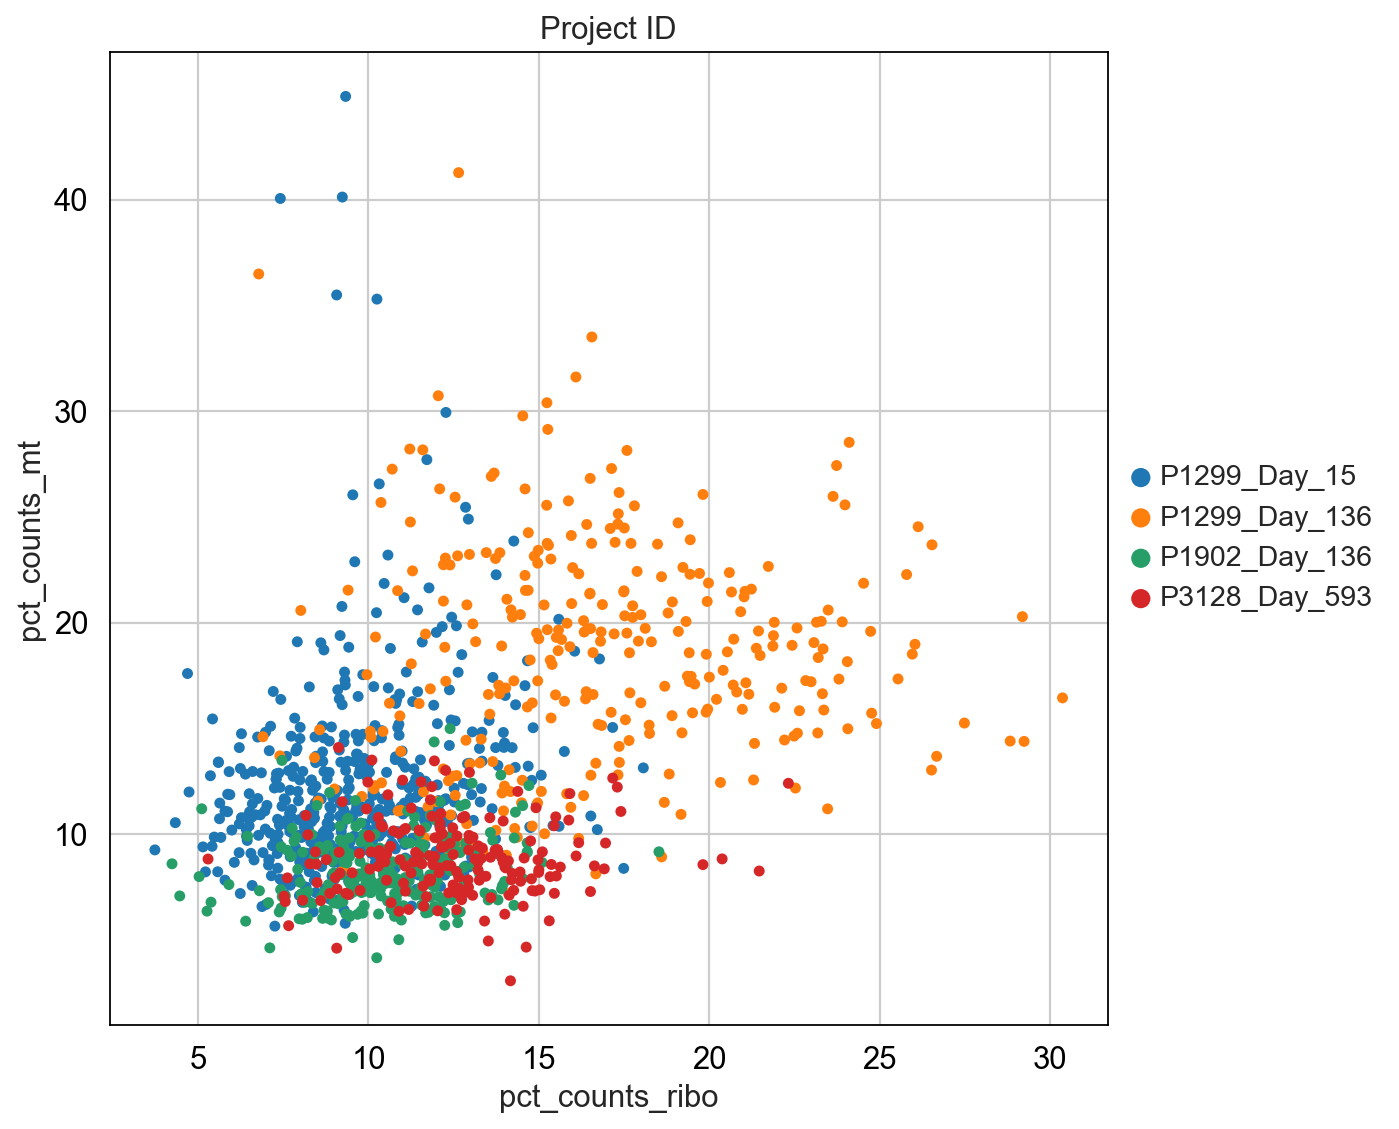

In [181]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sc.pl.scatter(adata, x='pct_counts_ribo', y='pct_counts_mt', color="Project_ID", ax=ax)


In [182]:
# filter for percent mito
adata = adata[adata.obs['pct_counts_mt'] < 30, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print("Remaining cells %d"%adata.n_obs)

Remaining cells 1219


## Filter genes

As the level of expression of mitochondrial and MALAT1 genes are judged as mainly technical, it can be wise to remove them from the dataset bofore any further analysis.


In [183]:
malat1 = adata.var_names.str.startswith('MALAT1')

keep = ~malat1

In [184]:
print(adata.n_obs, adata.n_vars)
adata = adata[:, keep]
print(adata.n_obs, adata.n_vars)

1219 63386
1219 63385


## Status after filtering

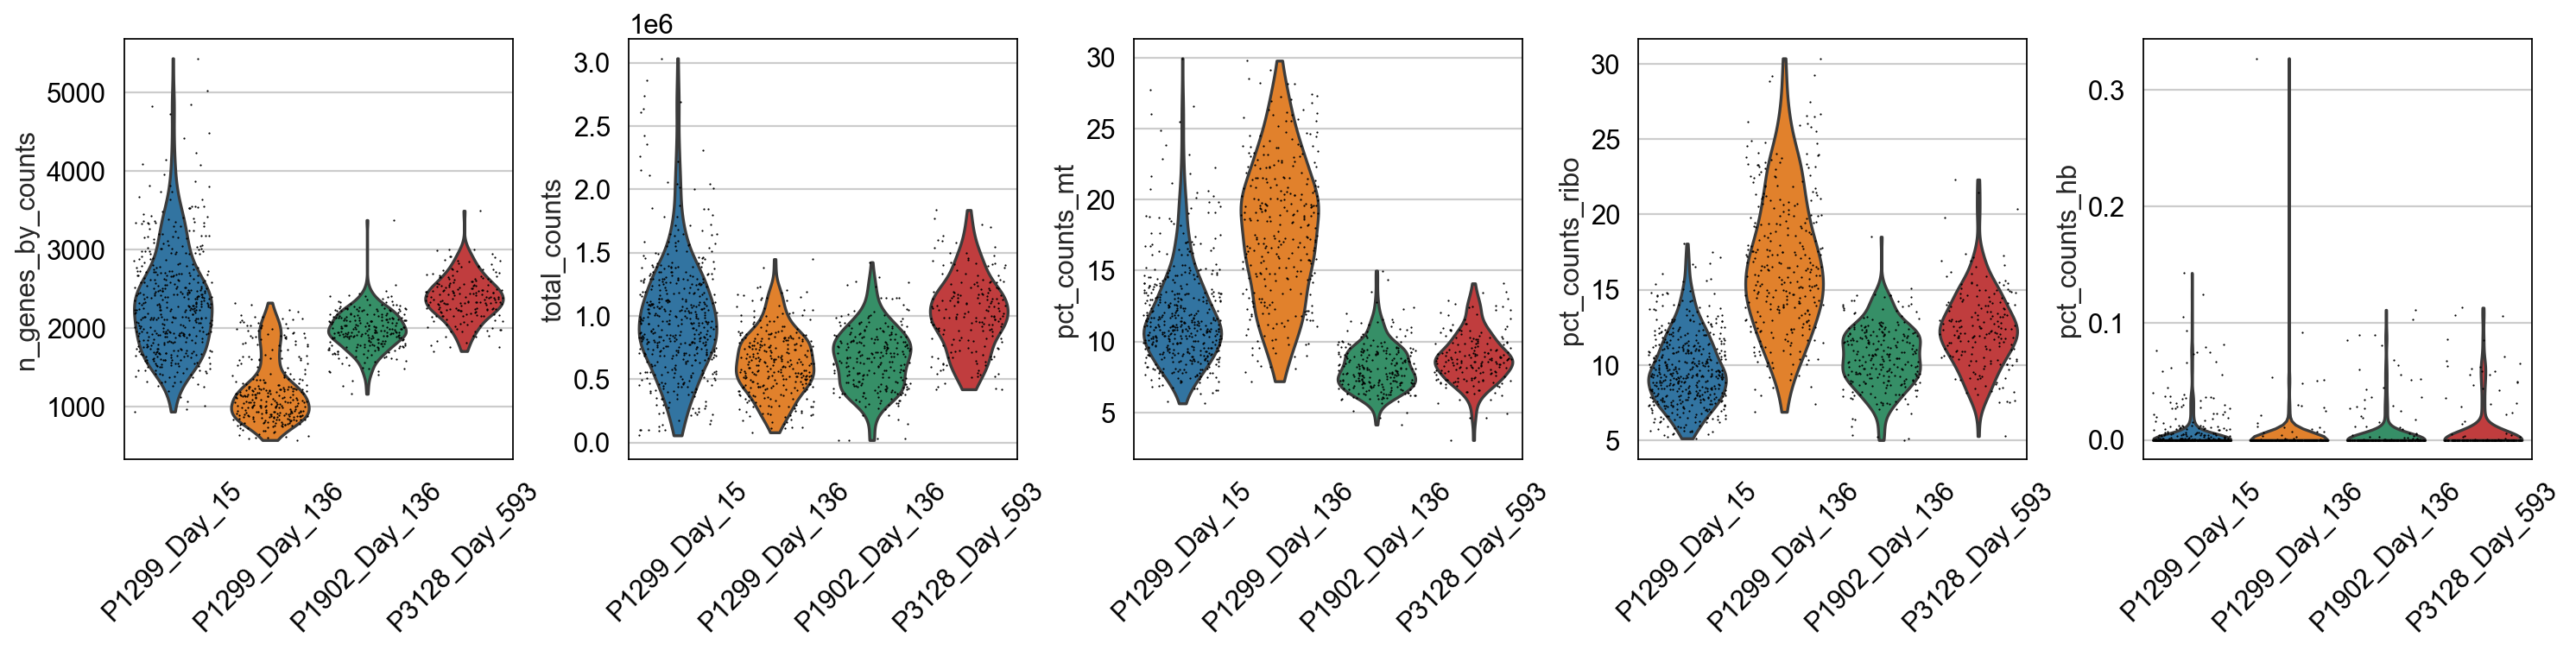

In [185]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'Project_ID', rotation = 45)

/Users/johard/miniconda3/envs/scanpy/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


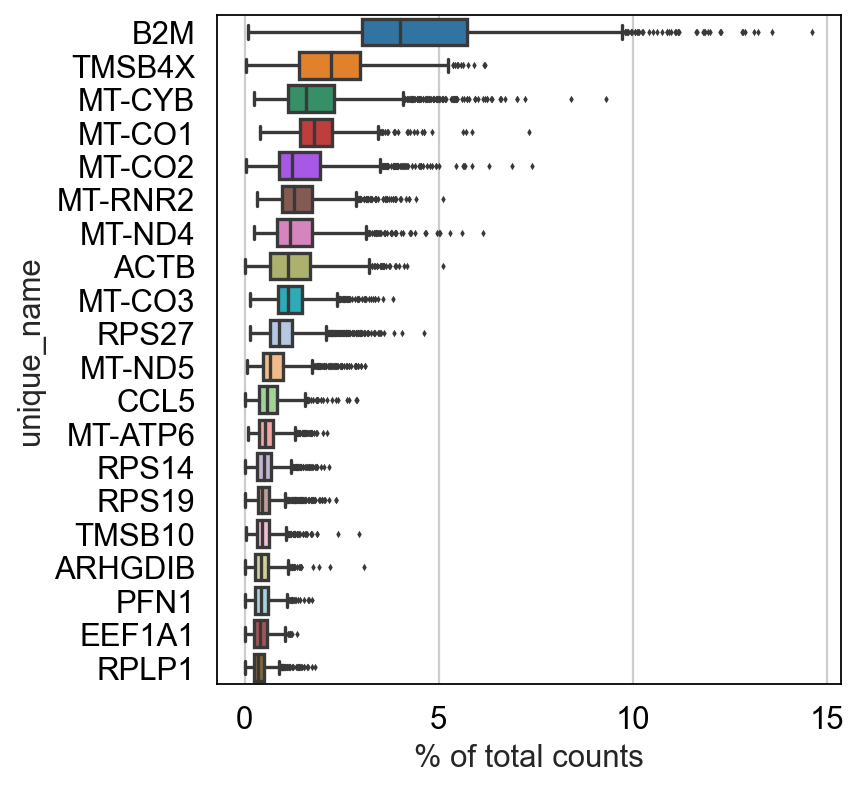

In [186]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Normalize and scale data

Before continuing we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot raw.

Then run normalization, logarimize and scale the data.

In [187]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
#sc.pp.log1p(adata)

# scale
#sc.pp.scale(adata)

In [188]:
adata.raw.X[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [189]:
adata.X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04012449, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.03010026, 0.        ,
        0.        ],
       [0.        , 0.15998422, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [190]:
adata.T.to_df().to_csv('../../data/YFV2001_gene_expression/results/YFV2001_230127_normalized_gene_counts.csv')

# Predict doublets

Doublets/Mulitples of cells in the same well/droplet is a common issue in scRNAseq protocols. Especially in droplet-based methods whith overloading of cells. In a typical 10x experiment the proportion of doublets is linearly dependent on the amount of loaded cells. As  indicated from the Chromium user guide, doublet rates are about as follows:
![](../../figs/10x_doublet_rate.png)
Most doublet detectors simulates doublets by merging cell counts and predicts doublets as cells that have similar embeddings as the simulated doublets. Most such packages need an assumption about the number/proportion of expected doublets in the dataset. The data you are using is subsampled, but the orignial datasets contained about 5 000 cells per sample, hence we can assume that they loaded about 9 000 cells and should have a doublet rate at about 4%.
OBS! Ideally doublet prediction should be run on each sample separately, especially if your different samples have different proportions of celltypes. In this case, the data is subsampled so we have very few cells per sample and all samples are sorted PBMCs so it is okay to run them together.



In [76]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])


ModuleNotFoundError: No module named 'scrublet'

In [30]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


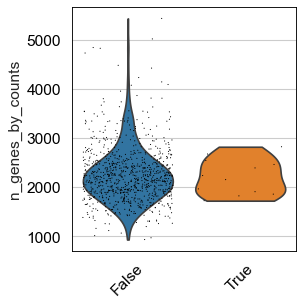

In [31]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby = 'doublet_info', rotation=45)

In [32]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

/Users/berkes/miniconda3/envs/genes/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/berkes/miniconda3/envs/genes/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


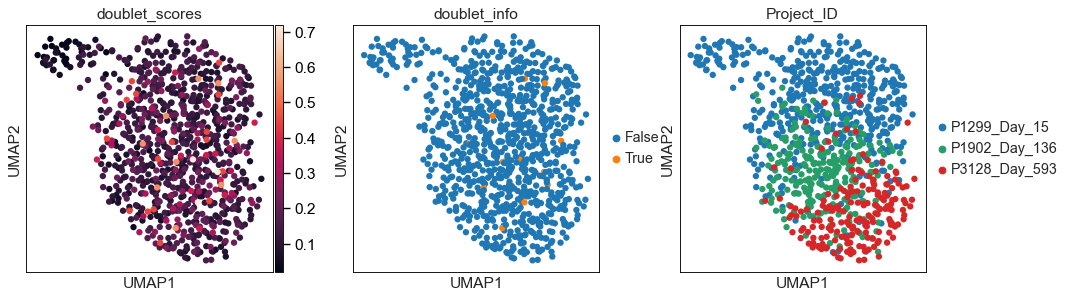

In [33]:
sc.pl.umap(adata, color=['doublet_scores','doublet_info','Project_ID'])


Now, lets remove all predicted doublets from our data.

In [34]:
adata

AnnData object with n_obs × n_vars = 917 × 2333
    obs: 'Day', 'Project_ID', 'Clone_ID', 'mem_score', 'n_mutations_tree', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'transcript_length', 'ENSG_ID', 'plain_name', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Project_ID_colors', 'log1p', 'doublet_info_colors', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [35]:
adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)

(905, 2333)


/Users/berkes/miniconda3/envs/genes/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Save data

In [36]:
# revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

In [37]:
save_file = '../../data/20210305_YFV2001_scRNAseq/results/YFV2001_202105_scanpy_data_filtered.h5ad'
adata.write_h5ad(save_file)